In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/Fake_News_BERT

/content/drive/My Drive/Fake_News_BERT


In [3]:
real_data = pd.read_csv('True.csv')
fake_data = pd.read_csv('Fake.csv') 

real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
# add label to all data
real_data["label"] = 0
fake_data["label"] = 1

In [6]:
real_data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [7]:
fake_data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [8]:
print("Total length of fake data", len(fake_data))
print("Total length of real data", len(real_data))

Total length of fake data 23481
Total length of real data 21417


In [9]:
# concate fake and real data 
from sklearn.utils import shuffle

data = pd.concat([real_data, fake_data])

# Shuffle the data
data = shuffle(data).reset_index(drop=True)
data.head()

,title,text,subject,date,label
0,EVIL GEORGE SOROS vs HUNGARIAN PM: The Battle ...,George Soros gets ugly with the name calling t...,Government News,"Nov 6, 2015",1
1,BREAKING: Sworn Affidavit PROVES Clinton ‘Vic...,Donald Trump thought bringing Juanita Broaddri...,News,"October 10, 2016",1
2,Less Than Half Of Trump Voters Believe Donald...,According to the results from a recent survey ...,News,"July 19, 2017",1
3,"U.S. voters say yes to big bond issues, mixed ...",(Reuters) - U.S. voters on Tuesday favored a s...,politicsNews,"November 9, 2016",0
4,Obama tax inversion rules may overstep authori...,WASHINGTON (Reuters) - President Barack Obama’...,politicsNews,"April 15, 2016",0


In [10]:
import re
def clean_txt(text):
    text = re.sub("'", "", text)
    text = re.sub("(\\W)+", " ", text)
    text = text.lower()
    return text

# data['text'] = data['text'].apply(clean_txt)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


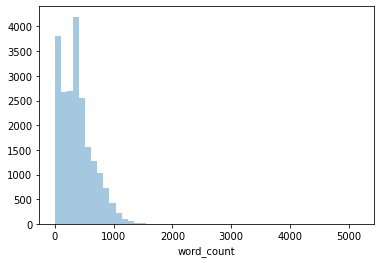

In [11]:
data['word_count'] = [len(s.split()) for s in data['text']]
#real 
sns.distplot(data['word_count'][data['label'] == 0], kde=False, rug=False)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


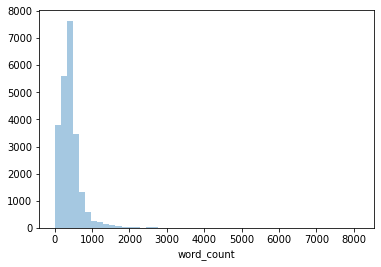

In [12]:
#fake 
sns.distplot(data['word_count'][data['label'] == 1], kde=False, rug=False)

In [13]:
# total news per subject
data["subject"].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [14]:
# fake news per subject
data[data["label"] == 1]["subject"].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [15]:
# real news per subject
data[data["label"] == 0]["subject"].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


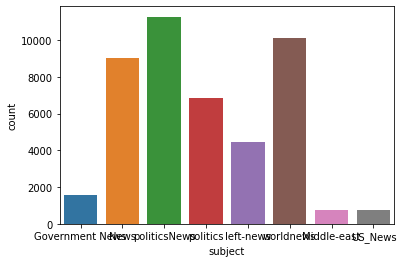

In [16]:
sns.countplot(data["subject"])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


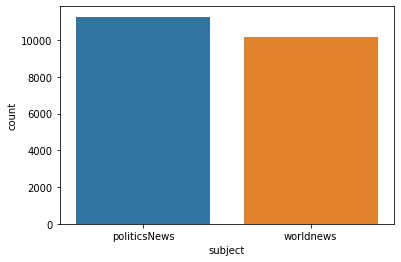

In [17]:
sns.countplot(data[data["label"] == 0]["subject"])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


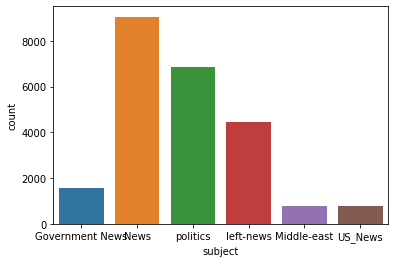

In [18]:
sns.countplot(data[data["label"] == 1]["subject"])

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.25, random_state=42)

In [21]:
!pip install transformers

In [22]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
model.config.num_labels = 1

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [23]:
# Freeze the pre trained parameters
for param in model.parameters():
    param.requires_grad = False

# Add three new layers at the end of the network
model.classifier = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
    nn.Softmax(dim=1)
)

model = model.to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

In [24]:
def preprocess_text(text):
    parts = []
    text_len = len(text.split(' '))
    delta = 300
    max_parts = 5
    nb_cuts = int(text_len / delta)
    nb_cuts = min(nb_cuts, max_parts)
        
    for i in range(nb_cuts + 1):
        text_part = ' '.join(text.split(' ')[i * delta: (i + 1) * delta])
        parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

    return parts

### Train model

In [25]:
print_every = 300
total_loss = 0
all_losses = []

CUDA_LAUNCH_BLOCKING=1

model.train()
idx = 0
for row, label in zip(X_train, y_train):
    text_parts = preprocess_text(str(row))
    label = torch.tensor([label]).long().to(device)
    optimizer.zero_grad()
    overall_output = torch.zeros((1, 2)).float().to(device)
    for part in text_parts:
        if len(part) > 0:
            try:
                input = part.reshape(-1)[:512].reshape(1, -1)
                # print(input.shape)
                overall_output += model(input, labels=label)[1].float().to(device)
            except Exception as e:
                print(str(e))

#     overall_output /= len(text_parts)
    overall_output = F.softmax(overall_output[0], dim=-1)

    if label == 0:
        label = torch.tensor([1.0, 0.0]).float().to(device)
    elif label == 1:
        label = torch.tensor([0.0, 1.0]).float().to(device)

    # print(overall_output, label)

    loss = criterion(overall_output, label)
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()

    if idx % print_every == 0 and idx > 0:
        average_loss = total_loss / print_every
        print("{}/{}. Average loss: {}".format(idx, len(X_train), average_loss))
        all_losses.append(average_loss)
        total_loss = 0
    idx += 1

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


300/33673. Average loss: 0.24499406894048056
600/33673. Average loss: 0.2234831730866184
900/33673. Average loss: 0.1969467364748319
1200/33673. Average loss: 0.1743896411594081
1500/33673. Average loss: 0.1571204985678196
1800/33673. Average loss: 0.13131526296715795
2100/33673. Average loss: 0.10861681620784415
2400/33673. Average loss: 0.11775071197858779
2700/33673. Average loss: 0.11364742883413176
3000/33673. Average loss: 0.11072270544025135
3300/33673. Average loss: 0.08826541552611161
3600/33673. Average loss: 0.10361143444567764
3900/33673. Average loss: 0.09350596546314288
4200/33673. Average loss: 0.085744520215776
4500/33673. Average loss: 0.09550129718314565
4800/33673. Average loss: 0.0874065300996881
5100/33673. Average loss: 0.09565096165216345
5400/33673. Average loss: 0.07565730300530049
5700/33673. Average loss: 0.08981805665204774
6000/33673. Average loss: 0.06766202066334699
6300/33673. Average loss: 0.07979847876525127
6600/33673. Average loss: 0.1097676940353994

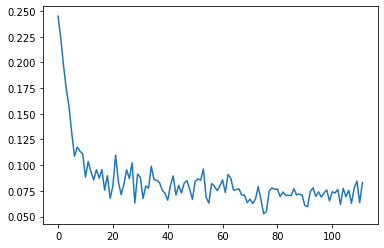

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

torch.save(model.state_dict(), "model.pt")
plt.plot(all_losses)

### Test Accuracy on Test Data

In [27]:
total = len(X_test)
number_right = 0
model.eval()
with torch.no_grad():
    idx = 0
    for row, label in zip(X_test, y_test):
        text_parts = preprocess_text(str(row))
        label = torch.tensor([label]).float().to(device)
        
        overall_output = torch.zeros((1,2)).to(device)
        try:
            for part in text_parts:
                if len(part) > 0:
                    overall_output += model(part.reshape(1, -1))[0]
        except RuntimeError:
            print("GPU out of memory, skipping this entry.")
            continue
            
        overall_output = F.softmax(overall_output[0], dim=-1)
            
        result = overall_output.max(0)[1].float().item()
 
        if result == label.item():
            number_right += 1
            
        if idx % print_every == 0 and idx > 0:
            print("{}/{}. Current accuracy: {}".format(idx, total, number_right / idx))
        idx += 1 
            
print("Accuracy on test data: {}".format(number_right / total))

300/11225. Current accuracy: 0.96
600/11225. Current accuracy: 0.965
900/11225. Current accuracy: 0.9588888888888889
1200/11225. Current accuracy: 0.9591666666666666
1500/11225. Current accuracy: 0.9586666666666667
1800/11225. Current accuracy: 0.9572222222222222
2100/11225. Current accuracy: 0.9580952380952381
2400/11225. Current accuracy: 0.9595833333333333
2700/11225. Current accuracy: 0.9607407407407408
3000/11225. Current accuracy: 0.9596666666666667
3300/11225. Current accuracy: 0.9581818181818181
3600/11225. Current accuracy: 0.9575
3900/11225. Current accuracy: 0.9579487179487179
4200/11225. Current accuracy: 0.9561904761904761
4500/11225. Current accuracy: 0.9568888888888889
4800/11225. Current accuracy: 0.9560416666666667
5100/11225. Current accuracy: 0.9531372549019608
5400/11225. Current accuracy: 0.9525925925925925
5700/11225. Current accuracy: 0.9529824561403509
6000/11225. Current accuracy: 0.955
6300/11225. Current accuracy: 0.9555555555555556
6600/11225. Current accura

In [38]:
def test(text):
    # text = clean_txt(text)
    text_parts = preprocess_text(text)
    overall_output = torch.zeros((1,2)).to(device)
    try:
        for part in text_parts:
            if len(part) > 0:
                overall_output += model(part.reshape(1, -1))[0]
    except RuntimeError:
        print("GPU out of memory, skipping this entry.")

    overall_output = F.softmax(overall_output[0], dim=-1)

    value, result = overall_output.max(0)
    term = "fake"
    if result.item() == 0:
        term = "real"

    print("{} at {}%".format(term, value.item() * 100))

In [39]:
fake = """
To confuse and add to the misleading of readers, World News Daily Report mixes some true stories with their fake ones.  Their disclaimer starts with a large headline reading "NEWS YOU CAN TRUST," however, when you scroll to the bottom of the page, it reads:

WNDR shall not be responsible for any incorrect or inaccurate information, whether caused by website users or by any of the equipment or programming associated with or utilized in this website or by any technical or human error which may occur.  WNDR assumes however all responsibility for the satirical nature of its articles and for the fictional nature of their content. All characters appearing in the articles in this website – even those based on real people –  are entirely fictional and any resemblance between them and any persons, living, dead, or undead is purely a miracle. 
"""

true = """
Price spikes, however, would cause demand to wither and some expensive avocados might be leftover, and stores might try to ration avocados, he added.
"Exactly what the retail strategy would be in this case, I’m not sure. But we would have vastly fewer avocados," Sumner said.
Just how fast avocados would disappear, if at all, would depend on whether the Trump administration enacts a full or partial border closure. White House economic adviser Larry Kudlow told CNBC he’s looking for ways to keep some commerce flowing.
"We are looking at different options, particularly if you can keep those freight lanes, the truck lanes, open," he said this week.  
Ben Holtz owns Rocky H Ranch, a 70-acre family-run avocado farm in northern San Diego County. He agreed avocados would run out within weeks.
"Mexico is the big player today. California is not. You shut down the border and California can’t produce to meet the demand," Holtz said. "There will be people without their guacamole."
While Mexico’s avocado harvest is year-round, California’s is limited to April through July. Growers in the state have picked only about 3 percent of what’s expected to be a much smaller crop of about 175 million pounds this year, Holtz said. A heat wave last summer reduced the crop size.
California’s avocado harvest has averaged approximately 300 million pounds in recent years, according to data from the California Avocado Commission. By contrast, the U.S. has imported more than 1.5 billion pounds of avocados from Mexico annually. Representatives from the commission did not respond to requests for this article.
Altogether, the U.S. received 43 percent of its fruit and vegetable imports from Mexico in 2016, according to the U.S. Department of Agriculture.
Also affecting this year’s avocado supply, a California avocado company in March recalled shipments to six states last month after fears the fruit might be contaminated with a bacterium that can cause health risks.
Until the early 2000s, California was the nation’s leading supplier of avocados, Holtz said. Mexico gradually overtook the state and now dominates sales in the U.S.
"It’s a very big possibility," Holtz said of avocado shortages. "Three weeks would dry up the Mexican inventory. California alone consumes more avocados than are grown in our state. Cold storage supply chain is basically three weeks or less of inventory. Most of the time it’s seven days."
A spokeswoman for the California Restaurant Association said "we haven’t heard concerns from restaurants, it doesn’t mean they aren’t worried." A national grocers association said it will "continue to closely monitor any developments" at the border, but did not have information about the potential impact on avocados.
"""

test(fake)
test(true)

fake at 73.0758786201477%
real at 87.9608690738678%
